<a href="https://colab.research.google.com/github/Butterflyer043/DL-Project/blob/main/CNN_SimilarityCheck.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import files

In [ ]:
# !pip install -q kaggle

In [3]:
uploaded = files.upload()

Saving kaggle.json to kaggle.json


In [7]:
!mkdir ~/.kaggle
!cp /content/kaggle.json ~/.kaggle/kaggle.json
!chmod 600 /root/.kaggle/kaggle.json
!kaggle datasets download -d paramaggarwal/fashion-product-images-dataset
#!kaggle datasets download -d paramaggarwal/fashion-product-images-small

mkdir: cannot create directory ‘/root/.kaggle’: File exists
100% 23.1G/23.1G [06:31<00:00, 53.5MB/s]



In [42]:
# !unzip fashion-product-images-dataset.zip
# !ls

In [15]:
#!unzip fashion-product-images-dataset.zip
!mv fashion-dataset/images /content 
!ls

mv: cannot stat 'fashion-dataset/images': No such file or directory
fashion-dataset			    images	 sample_data
fashion-product-images-dataset.zip  kaggle.json  styles.csv


In [16]:
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt # plotting
import matplotlib.image as mpimg
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os # accessing directory structure

In [17]:
df = pd.read_csv("styles.csv", nrows = 5000, error_bad_lines=False)

In [22]:
df['image'] = df.apply(lambda row: str(row['id']) + ".jpg", axis=1)
df = df.reset_index(drop=True)
df.head(10)

,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName,image
0,15970,Men,Apparel,Topwear,Shirts,Navy Blue,Fall,2011,Casual,Turtle Check Men Navy Blue Shirt,15970.jpg
1,39386,Men,Apparel,Bottomwear,Jeans,Blue,Summer,2012,Casual,Peter England Men Party Blue Jeans,39386.jpg
2,59263,Women,Accessories,Watches,Watches,Silver,Winter,2016,Casual,Titan Women Silver Watch,59263.jpg
3,21379,Men,Apparel,Bottomwear,Track Pants,Black,Fall,2011,Casual,Manchester United Men Solid Black Track Pants,21379.jpg
4,53759,Men,Apparel,Topwear,Tshirts,Grey,Summer,2012,Casual,Puma Men Grey T-shirt,53759.jpg
5,1855,Men,Apparel,Topwear,Tshirts,Grey,Summer,2011,Casual,Inkfruit Mens Chain Reaction T-shirt,1855.jpg
6,30805,Men,Apparel,Topwear,Shirts,Green,Summer,2012,Ethnic,Fabindia Men Striped Green Shirt,30805.jpg
7,26960,Women,Apparel,Topwear,Shirts,Purple,Summer,2012,Casual,Jealous 21 Women Purple Shirt,26960.jpg
8,29114,Men,Accessories,Socks,Socks,Navy Blue,Summer,2012,Casual,Puma Men Pack of 3 Socks,29114.jpg
9,30039,Men,Accessories,Watches,Watches,Black,Winter,2016,Casual,Skagen Men Black Watch,30039.jpg


In [23]:
import cv2
def plot_figures(figures, nrows = 1, ncols=1,figsize=(8, 8)):
    """Plot a dictionary of figures.

    Parameters
    ----------
    figures : <title, figure> dictionary
    ncols : number of columns of subplots wanted in the display
    nrows : number of rows of subplots wanted in the figure
    """

    fig, axeslist = plt.subplots(ncols=ncols, nrows=nrows,figsize=figsize)
    for ind,title in enumerate(figures):
        axeslist.ravel()[ind].imshow(cv2.cvtColor(figures[title], cv2.COLOR_BGR2RGB))
        axeslist.ravel()[ind].set_title(title)
        axeslist.ravel()[ind].set_axis_off()
    plt.tight_layout() # optional
    
def img_path(img):
    return "images/"+img

def load_image(img, resized_fac = 1):
    img     = cv2.imread(img_path(img))
    w, h, _ = img.shape
    resized = cv2.resize(img, (int(h*resized_fac), int(w*resized_fac)), interpolation = cv2.INTER_AREA)
    return resized

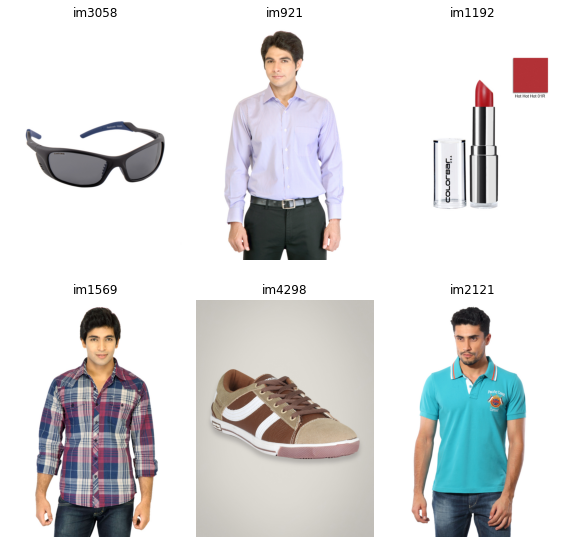

In [24]:
import matplotlib.pyplot as plt
import numpy as np

# generation of a dictionary of (title, images)
figures = {'im'+str(i): load_image(row.image) for i, row in df.sample(6).iterrows()}
# plot of the images in a figure, with 2 rows and 3 columns
plot_figures(figures, 2, 3)

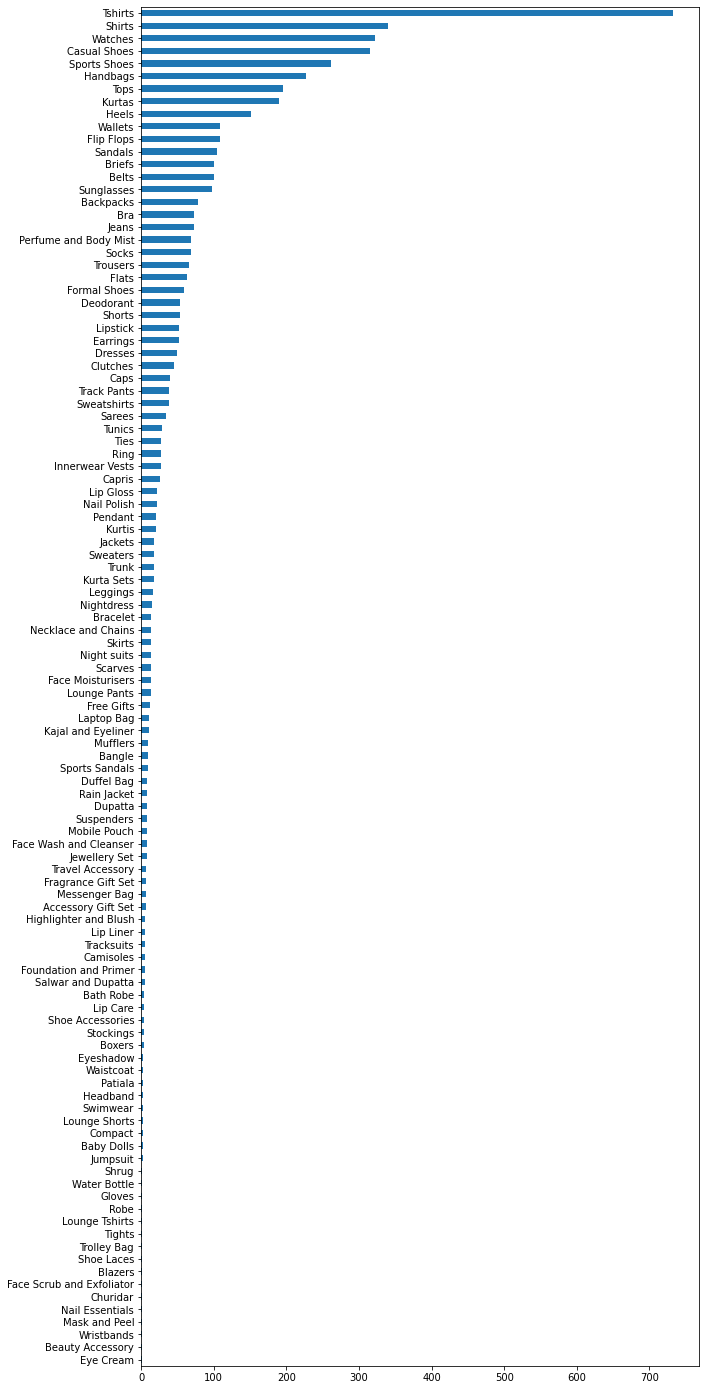

In [133]:
plt.figure(figsize=(10,25))
df.articleType.value_counts().sort_values().plot(kind='barh')

In [25]:
import tensorflow as tf
import keras
from keras import Model
from keras.applications.resnet50 import ResNet50
from keras.preprocessing import image
from keras.applications.resnet50 import preprocess_input, decode_predictions
from keras.layers import GlobalMaxPooling2D
tf.__version__

'2.3.0'

In [26]:
# Input Shape
img_width, img_height, _ = 224, 224, 3 #load_image(df.iloc[0].image).shape

# Pre-Trained Model
base_model = ResNet50(weights='imagenet', 
                      include_top=False, 
                      input_shape = (img_width, img_height, 3))
base_model.trainable = False

# Add Layer Embedding
model = keras.Sequential([
    base_model,
    GlobalMaxPooling2D()
])

model.summary()

94773248/94765736 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
global_max_pooling2d (Global (None, 2048)              0         
Total params: 23,587,712
Trainable params: 0
Non-trainable params: 23,587,712
_________________________________________________________________


In [27]:
def get_embedding(model, img_name):
    # Reshape
    img = image.load_img(img_path(img_name), target_size=(img_width, img_height))
    # img to Array
    x   = image.img_to_array(img)
    # Expand Dim (1, w, h)
    x   = np.expand_dims(x, axis=0)
    # Pre process Input
    x   = preprocess_input(x)
    return model.predict(x).reshape(-1)

(1440, 1080, 3)
[ 0.75675344  4.4093304   0.         ...  0.         28.343306
  4.4179926 ]


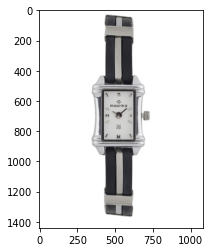

In [28]:
emb = get_embedding(model, df.iloc[50].image)
emb.shape
img_array = load_image(df.iloc[50].image)
plt.imshow(cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB))
print(img_array.shape)
print(emb)

In [29]:
df.shape

(5000, 11)

In [29]:
#%%time
#import swifter
# Parallel apply
df_sample      = df#.sample(10)
map_embeddings = df_sample['image'].apply(lambda img: get_embedding(model, img))
df_embs        = map_embeddings.apply(pd.Series)

print(df_embs.shape)
df_embs.head()

(5000, 2048)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024,2025,2026,2027,2028,2029,2030,2031,2032,2033,2034,2035,2036,2037,2038,2039,2040,2041,2042,2043,2044,2045,2046,2047
0,5.661306,2.366162,0.000000,3.255733,0.845210,2.673837,8.780888,6.280783,0.787186,1.587660,4.747005,2.194435,1.390058,0.084759,5.621378,1.438352,0.846029,3.746689,0.565090,3.239837,10.690898,17.546301,0.409632,9.395816,2.264080,3.299497,0.000000,2.646154,3.106113,6.388959,2.960275,2.590649,7.436981,12.966867,11.129395,1.509901,3.419743,2.780665,5.122319,1.172127,...,5.891071,1.397223,10.657393,5.285227,12.454018,0.244773,0.000000,0.000000,0.124152,3.678559,0.000000,6.451393,0.222925,2.146197,0.000000,0.000000,4.869761,0.013102,10.417797,4.593729,1.706276,2.295292,1.174044,1.143257,4.330000,0.000000,3.820597,9.129350,5.367465,11.374366,2.463608,0.000000,1.825995,20.485273,3.902869,0.000000,8.225966,1.313869,0.000000,10.820531
1,5.790412,9.593642,0.000000,9.431683,0.287240,0.259951,17.028759,3.037453,0.136339,0.000000,1.965359,11.357365,0.000000,1.469505,15.389229,1.571158,1.763885,10.389544,0.148096,3.524307,7.055554,30.510334,1.271798,3.311808,0.114733,10.653406,0.000000,6.562443,0.649472,7.688971,3.051671,8.958171,4.189043,0.000000,21.179901,0.000000,2.440779,8.458698,0.000000,3.771063,...,0.677629,0.000000,0.000000,0.605004,0.858280,1.966207,0.000000,0.599206,5.639309,6.169497,0.759208,5.618349,2.140228,2.764191,1.375176,0.000000,0.356267,0.060566,1.761377,3.963813,1.113939,0.861969,1.591129,0.414464,0.000000,0.000000,0.000000,2.049299,3.058013,13.099395,1.670568,0.013895,10.338684,4.784727,0.189141,0.000000,7.739132,0.372703,0.000000,8.903798
2,0.000000,3.162255,0.484691,0.172310,2.609545,3.840854,3.426130,0.253251,1.098899,1.418286,4.961282,0.019916,1.184377,1.968402,0.000000,0.725641,0.000000,3.489890,2.328228,5.015535,1.741451,6.192958,5.083102,1.830225,7.724955,0.000000,4.701734,3.938360,2.256486,6.721399,1.096143,1.510840,2.458783,20.105591,6.312136,4.848500,3.993414,7.806202,0.355124,4.775936,...,9.827850,5.443032,5.476727,14.178022,8.461706,4.325662,2.769818,2.257813,0.000000,12.230948,4.733219,0.508864,7.315336,4.136791,6.273545,1.941373,1.422209,3.393705,6.287760,1.288340,8.118605,5.822617,1.269089,4.585337,4.213085,9.219348,4.636050,3.688563,0.000000,4.704537,0.434924,14.092843,3.018760,2.134508,2.549058,0.377389,6.180353,0.636625,14.018172,11.415049
3,5.882213,1.958618,0.000000,12.519886,0.000000,0.000000,9.383587,3.781618,0.000000,1.490623,1.974221,5.454761,0.000000,1.755712,8.076468,0.000000,1.223884,0.583671,5.152811,6.677150,0.000000,23.285608,1.119269,3.193377,0.000000,16.064062,0.000000,12.981682,0.698518,5.192165,1.083938,17.083317,1.264484,0.547192,17.513783,0.000000,0.000000,12.259812,0.764782,2.011019,...,3.724134,0.666892,0.000000,0.349405,3.286713,3.351324,8.246608,0.000000,0.428232,2.523222,10.244483,7.463436,3.938654,2.660910,0.171212,1.656346,1.137167,5.451193,6.848457,3.476729,0.000000,8.251842,0.000000,1.300370,2.128897,0.109026,0.000000,8.019861,5.730196,18.058071,17.825478,0.000000,3.592515,2.042309,0.000000,0.000000,6.656779,1.457317,1.694212,1.403329
4,0.245961,17.383434,0.493822,3.374463,2.567364,0.000000,6.482543,5.862634,0.000000,3.164866,2.575928,2.675663,0.000000,0.185373,5.284717,2.591624,1.191178,1.860985,2.442796,4.733860,1.282961,20.822006,1.530982,3.385109,2.184118,3.610811,0.176618,1.812313,1.203808,6.053123,1.056428,5.902718,6.321792,11.143506,9.269874,1.631086,2.694299,2.185788,6.799668,3.059346,...,4.719404,1.797235,0.298094,4.900356,7.590143,0.588043,2.806741,0.179699,1.040509,3.476844,3.355670,3.278838,0.000000,0.921918,0.016547,0.820265,7.446559,4.418407,3.672615,1.710772,0.000000,4.964252,0.356461,0.000000,0.699825,5.051840,2.299203,3.773075,0.012485,12.812891,4.464022,0.447085,1.448140,12.884135,0.000000,0.397489,5.028071,1.939695,0.000000,11.485394


In [30]:
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise_distances.html
from sklearn.metrics.pairwise import pairwise_distances

# Calcule DIstance Matriz
cosine_sim = 1-pairwise_distances(df_embs, metric='cosine')
cosine_sim[:4, :4]

array([[1.        , 0.71344966, 0.4542722 , 0.679706  ],
       [0.71344966, 0.99999905, 0.41515303, 0.8333087 ],
       [0.4542722 , 0.41515303, 0.99999857, 0.44629467],
       [0.679706  , 0.8333087 , 0.44629467, 0.99999917]], dtype=float32)

In [31]:
indices = pd.Series(range(len(df)), index=df.index)
indices

# Function that get clothes recommendations based on the cosine similarity score of fashion articles 
def get_recommender(idx, df, top_n = 5):
    sim_idx    = indices[idx]
    sim_scores = list(enumerate(cosine_sim[sim_idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:top_n+1]
    idx_rec    = [i[0] for i in sim_scores]
    idx_sim    = [i[1] for i in sim_scores]
    
    return indices.iloc[idx_rec].index, idx_sim

get_recommender(2993, df, top_n = 5)

(Int64Index([251, 659, 2400, 0, 1821], dtype='int64'),
 [0.92362803, 0.92232656, 0.9190423, 0.91508687, 0.9131174])

### The model performs well for Accessories and Footwear

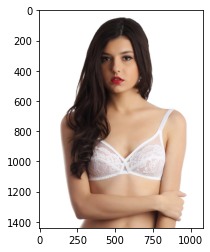

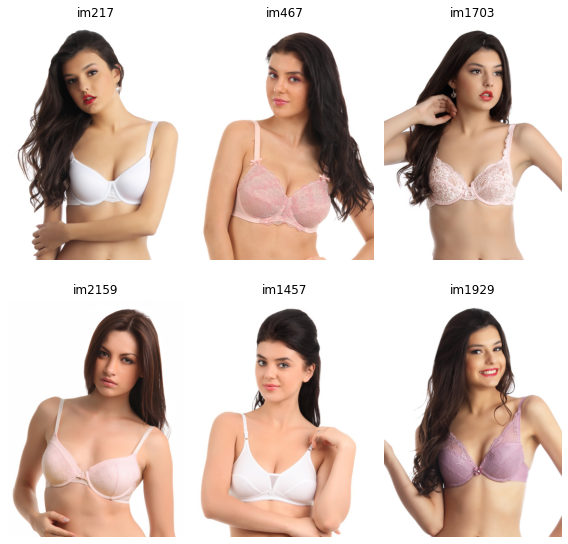

In [32]:
# Idx Item to Recommender
idx_ref = 1989

# Recommendations
idx_rec, idx_sim = get_recommender(idx_ref, df, top_n = 6)

# Plot
#===================
plt.imshow(cv2.cvtColor(load_image(df.iloc[idx_ref].image), cv2.COLOR_BGR2RGB))

# generation of a dictionary of (title, images)
figures = {'im'+str(i): load_image(row.image) for i, row in df.loc[idx_rec].iterrows()}
# plot of the images in a figure, with 2 rows and 3 columns
plot_figures(figures, 2, 3)

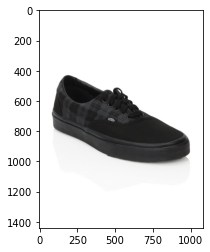

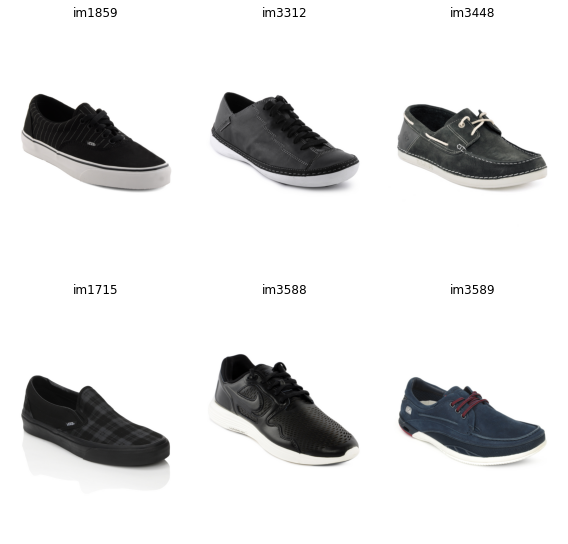

In [149]:
idx_ref = 4399

# Recommendations
idx_rec, idx_sim = get_recommender(idx_ref, df, top_n = 6)

# Plot
#===================
plt.imshow(cv2.cvtColor(load_image(df.iloc[idx_ref].image), cv2.COLOR_BGR2RGB))

# generation of a dictionary of (title, images)
figures = {'im'+str(i): load_image(row.image) for i, row in df.loc[idx_rec].iterrows()}
# plot of the images in a figure, with 2 rows and 3 columns
plot_figures(figures, 2, 3)

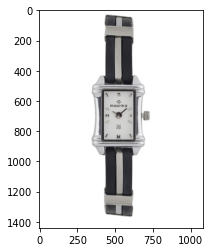

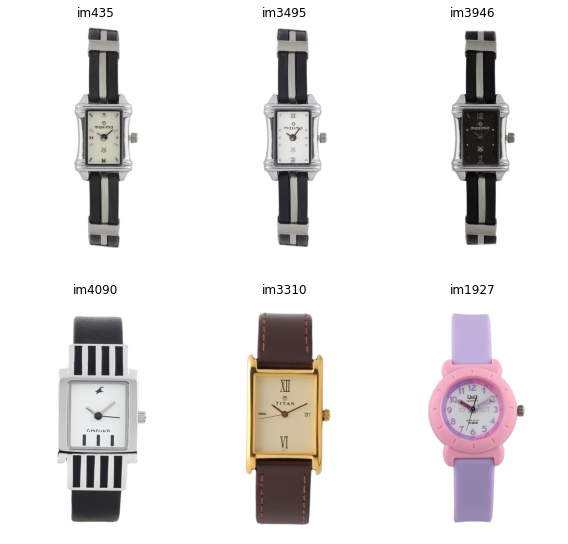

In [33]:
idx_ref = 50

# Recommendations
idx_rec, idx_sim = get_recommender(idx_ref, df, top_n = 6)

# Plot
#===================
plt.imshow(cv2.cvtColor(load_image(df.iloc[idx_ref].image), cv2.COLOR_BGR2RGB))

# generation of a dictionary of (title, images)
figures = {'im'+str(i): load_image(row.image) for i, row in df.loc[idx_rec].iterrows()}
# plot of the images in a figure, with 2 rows and 3 columns
plot_figures(figures, 2, 3)

### The model does not perform as well for Personal Care

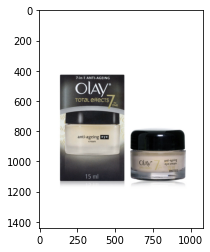

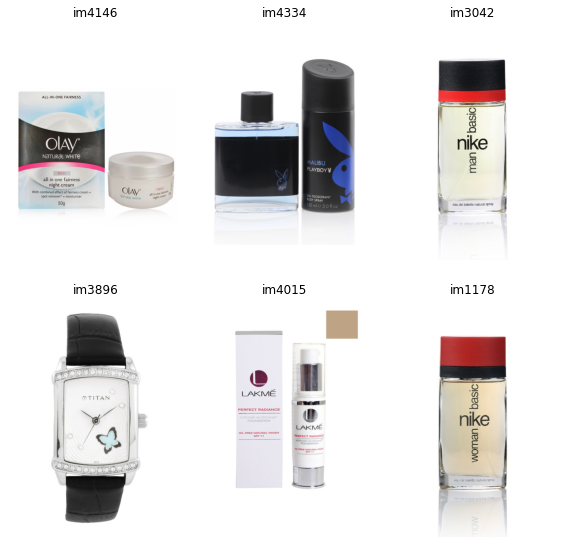

In [41]:
idx_ref = 1024

# Recommendations
idx_rec, idx_sim = get_recommender(idx_ref, df, top_n = 6)

# Plot
#===================
plt.imshow(cv2.cvtColor(load_image(df.iloc[idx_ref].image), cv2.COLOR_BGR2RGB))

# generation of a dictionary of (title, images)
figures = {'im'+str(i): load_image(row.image) for i, row in df.loc[idx_rec].iterrows()}
# plot of the images in a figure, with 2 rows and 3 columns
plot_figures(figures, 2, 3)

## Visualization

In [34]:
from sklearn.manifold import TSNE
import time
import seaborn as sns

In [46]:
df.head()


,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName,image
0,15970,Men,Apparel,Topwear,Shirts,Navy Blue,Fall,2011,Casual,Turtle Check Men Navy Blue Shirt,15970.jpg
1,39386,Men,Apparel,Bottomwear,Jeans,Blue,Summer,2012,Casual,Peter England Men Party Blue Jeans,39386.jpg
2,59263,Women,Accessories,Watches,Watches,Silver,Winter,2016,Casual,Titan Women Silver Watch,59263.jpg
3,21379,Men,Apparel,Bottomwear,Track Pants,Black,Fall,2011,Casual,Manchester United Men Solid Black Track Pants,21379.jpg
4,53759,Men,Apparel,Topwear,Tshirts,Grey,Summer,2012,Casual,Puma Men Grey T-shirt,53759.jpg


In [35]:
time_start = time.time()
tsne = TSNE(n_components=2, verbose=0, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(df_embs)
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

t-SNE done! Time elapsed: 150.20079278945923 seconds


In [36]:
df['tsne-2d-one'] = tsne_results[:,0]
df['tsne-2d-two'] = tsne_results[:,1]

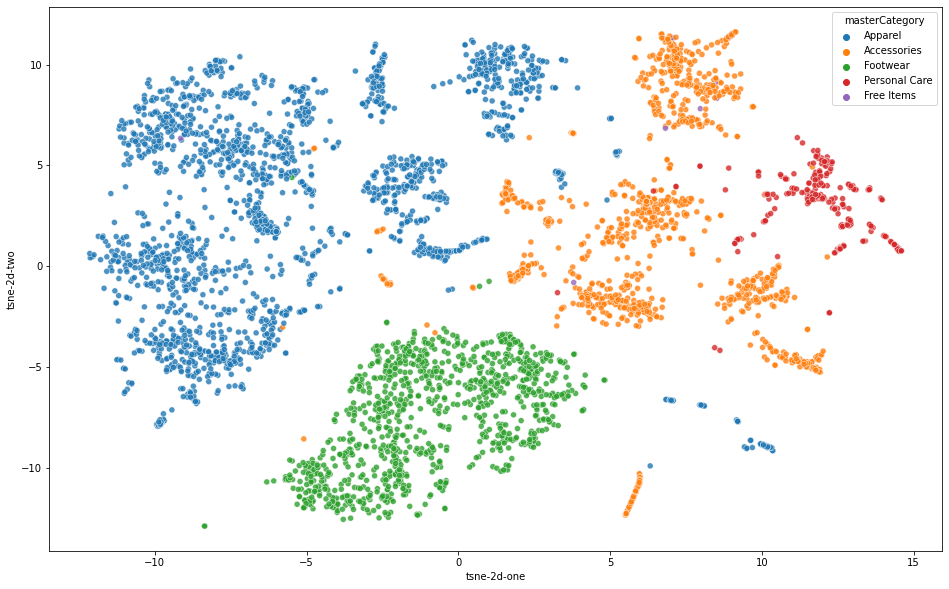

In [37]:
plt.figure(figsize=(16,10))
sns.scatterplot(x="tsne-2d-one", y="tsne-2d-two",
                hue="masterCategory",
                data=df,
                legend="full",
                alpha=0.8)

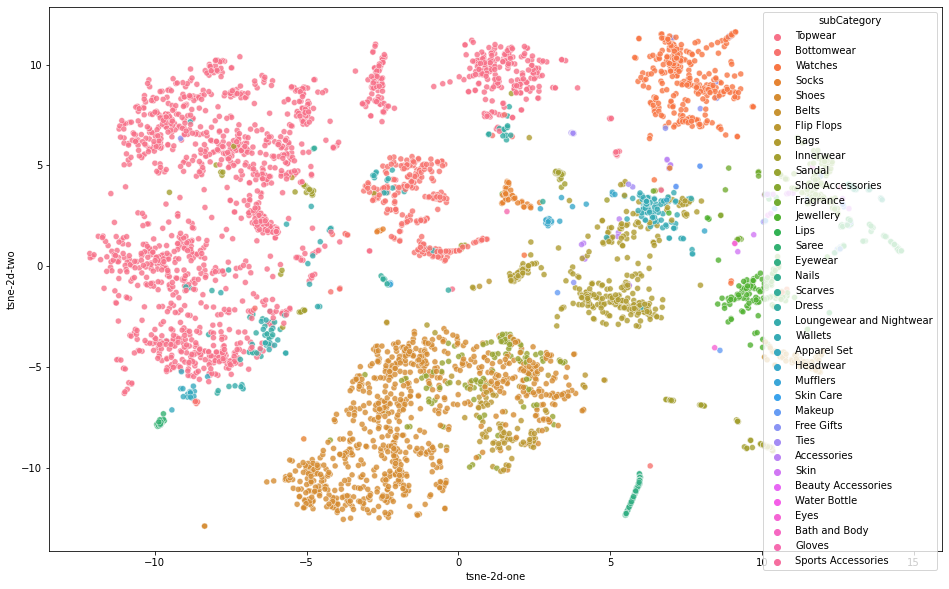

In [38]:
plt.figure(figsize=(16,10))
sns.scatterplot(x="tsne-2d-one", y="tsne-2d-two",
                hue="subCategory",
                data=df,
                legend="full",
                alpha=0.8)

overlapping

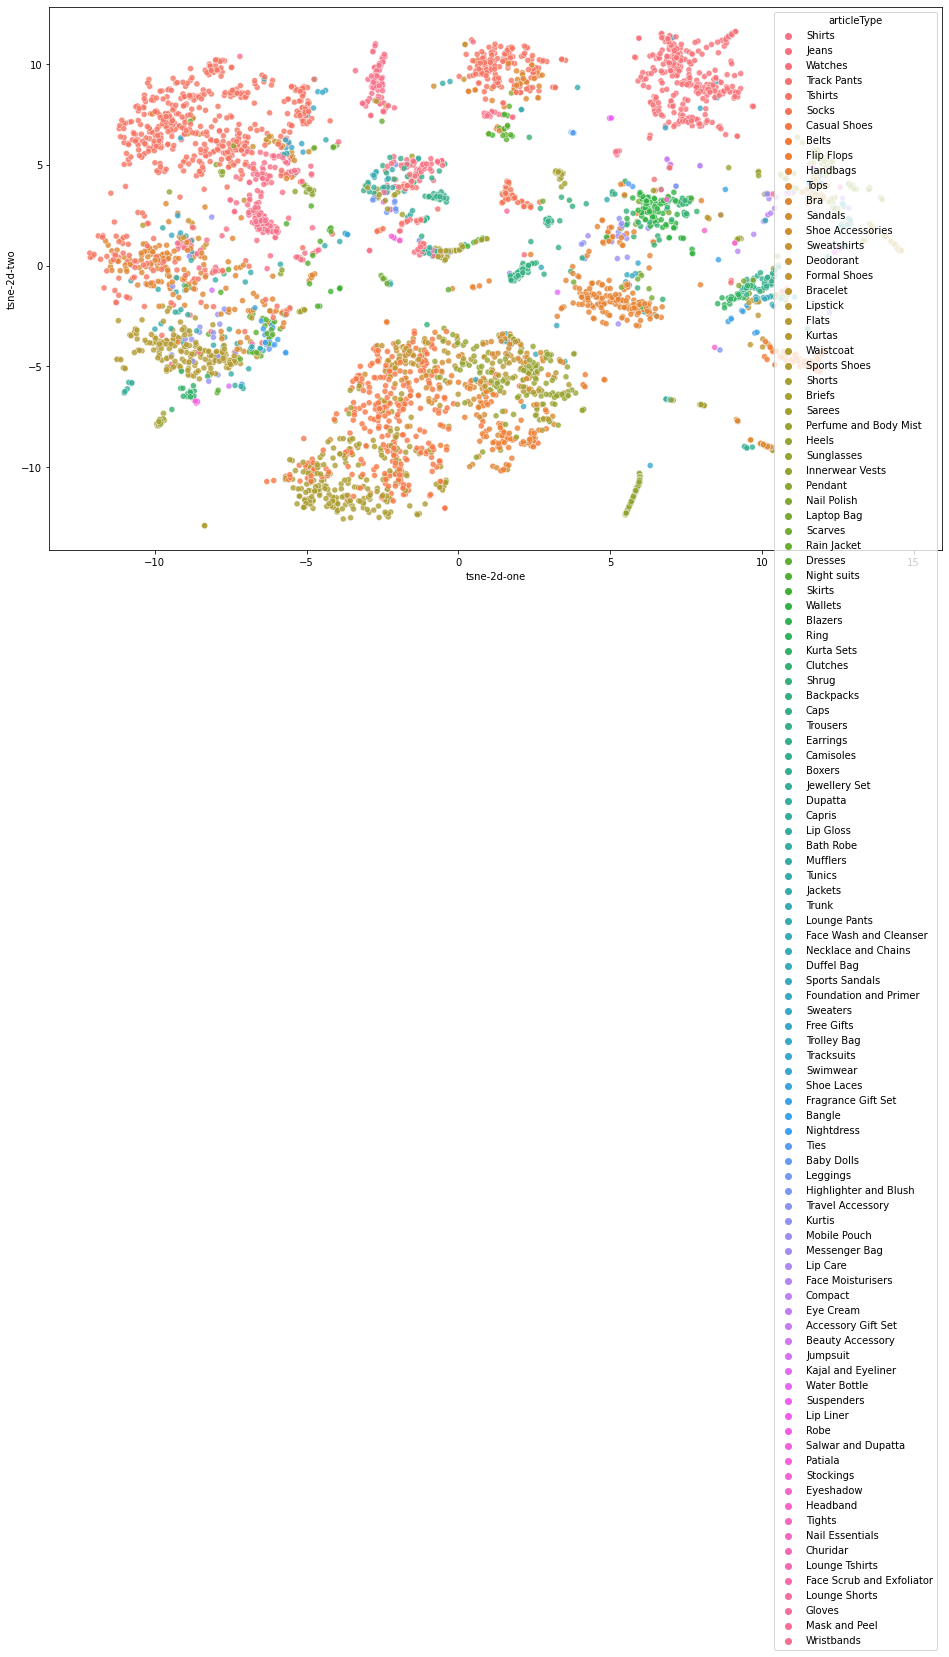

In [40]:
plt.figure(figsize=(16,10))
sns.scatterplot(x="tsne-2d-one", y="tsne-2d-two",
                hue="articleType",
                data=df,
                #legend="full",
                alpha=0.8)

even more overlapping

In [56]:
df_embs.to_csv('df_embs.csv')
df.to_csv('df.csv')

In [57]:
!ls

df.csv	     fashion-product-images-small.zip  kaggle.json    sample_data
df_embs.csv  images			       myntradataset  styles.csv
